### กลุ่ม Diabetes Prediction
1. 6610402205 นายรักษิต รุ่งรัตนไชย หมู่ 1
2. 6610402132 นายบวรรัตน์ ตั้งนรารัชชกิจ หมู่ 1
3. 6610401985 นายไชยวัตน์ หนูวัฒนา หมู่ 1

### วัตถุประสงค์ของระบบต้นแบบ

กลุ่มของพวกเราเล็งเห็นถึงความสำคัญทางด้านสุขภาพของประชาชนคนไทย ในปัจจุบันคนไทยประสบกับปัญหาสุขภาพมากมายแต่หนึ่งปัญหาที่สร้างความเสียหายให้กับสุขภาพ และคนไทยเป็นกันมากที่สุดนั่นคือโรคเบาหวาน พฤติกรรมการใช้ชีวิตของคนไทยในสมัยนี้ก็เป็นปัจจัยหนึ่งที่ทำให้ปริมาณผู้ป่วยโรคเบาหวานเพิ่มมากยิ่งขึ้น พวกเราจึงอยากทำระบบต้นแบบที่ช่วยชี้แนะหรือแนะนำผู้ที่มาใช้งานระบบต้นแบบของเราว่ามีความเสี่ยงที่จะเป็นโรคเบาหวานหรือไม่เพื่อให้เกิดการตระหนักและระมัดระวังในพฤติกรรมการใช้ชีวิตของตนเองซึ่งระบบต้นแบบของเราไม่ได้แม่นยำ 100 เปอร์เซ็นต์ ไม่สามารถใช้วินิจฉัยโรคได้แต่ใช้ประเมินความเสี่ยงเบื่องต้นของผู้ที่มาใช้งานระบบได้หากมีความเสี่ยงก็สามารถให้แพทย์วินิจัยอย่างถูกต้องและแม่นยำต่อไป

### ลิงค์ไปยังข้อมูลที่จะใช้ในระบบต้นแบบ

Link to data: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

In [1]:
import pandas as pd

diabetes = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")

ตรวจสอบข้อมูลสูญหาย (missing value) พบว่าไม่มีข้อมูลสูญหาย

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

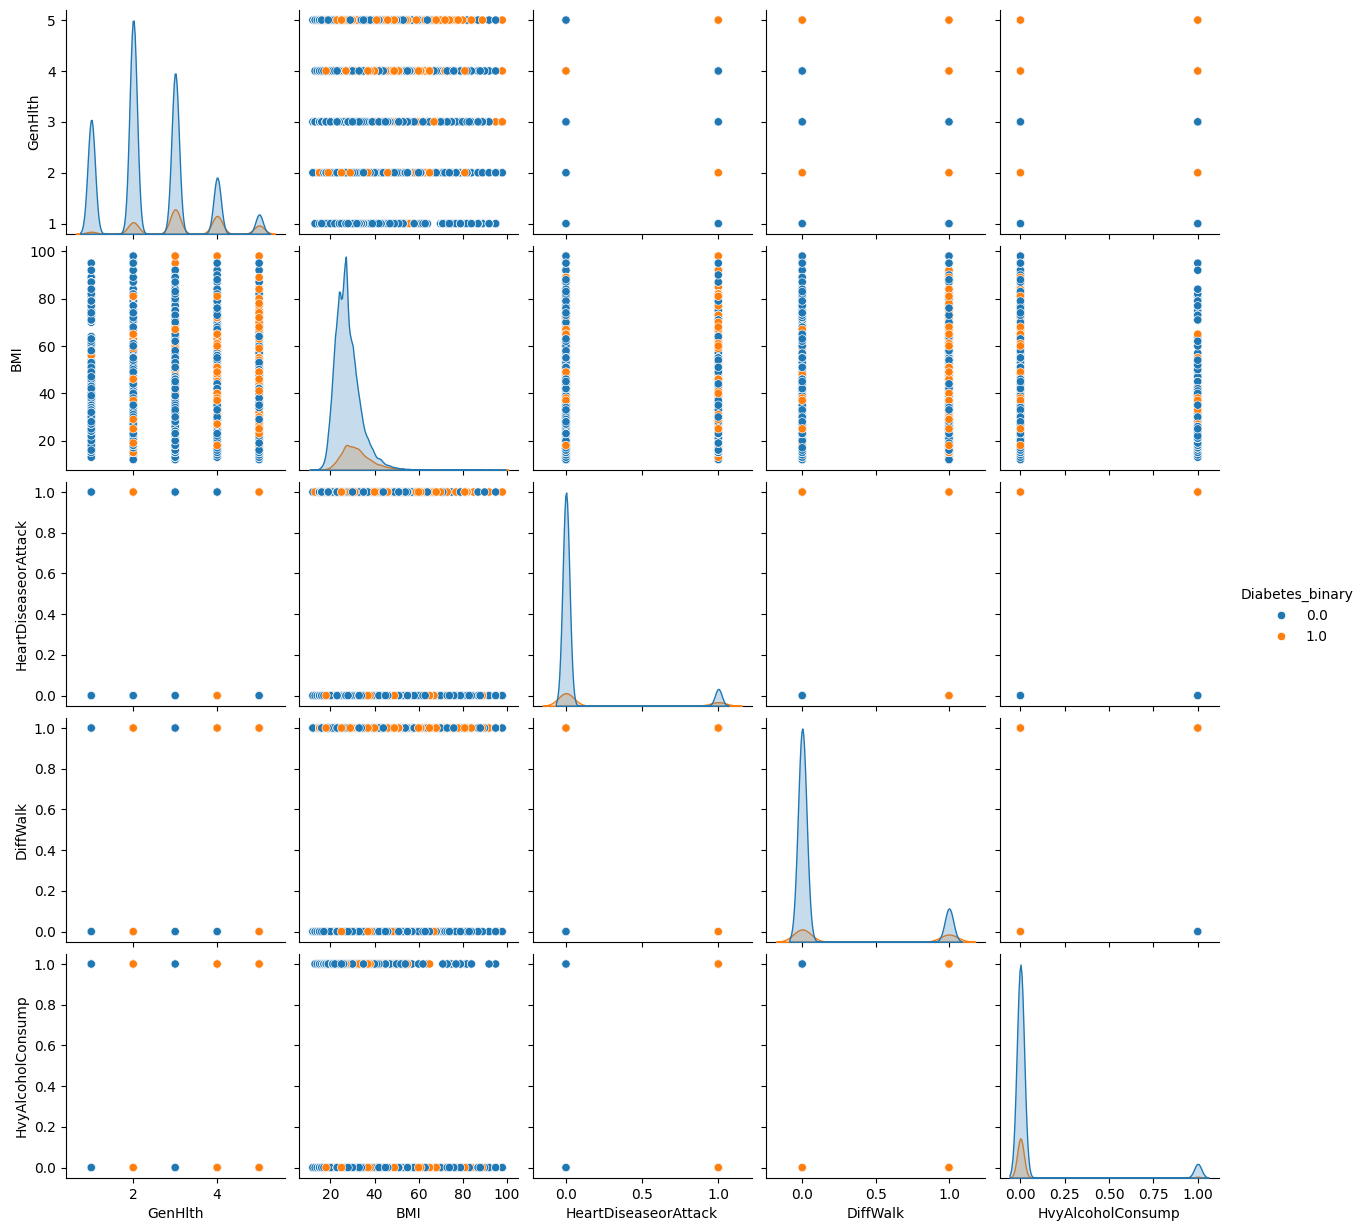

In [3]:
sns.pairplot(diabetes[["GenHlth", "BMI", "HeartDiseaseorAttack", "DiffWalk", "HvyAlcoholConsump", "Diabetes_binary"]], hue="Diabetes_binary")
plt.show()

In [4]:
diabetes.isna().sum()

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

จัดการกับข้อมูลที่ซ้ำซ้อน

In [5]:
diabetes.duplicated().sum() 

np.int64(24206)

In [6]:
diabetes.drop_duplicates(inplace=True)

features ที่นำมาใช้นั้นผ่านกระบวนการ feature importance จากครั้งก่อนๆแล้วซึ่งสรุปว่าเป็น feature ที่ส่งผลต่อประสิทธิภาพของโมเดลมากที่สุด

In [7]:
features = ["GenHlth", "BMI", "HeartDiseaseorAttack", "DiffWalk", "HvyAlcoholConsump"]

# features = diabetes.drop("Diabetes_binary", axis=1).columns
label = "Diabetes_binary"

จัดการกับ imbalance ภายในข้อมูล ด้วยการ undersampler

In [8]:
from imblearn.under_sampling import RandomUnderSampler
resampler = RandomUnderSampler(random_state=1234)

diabetes[features], diabetes[label] = resampler.fit_resample(diabetes[features], diabetes[label])
diabetes.dropna(inplace=True)

diabetes[features].head()

,GenHlth,BMI,HeartDiseaseorAttack,DiffWalk,HvyAlcoholConsump
8,5.0,30.0,1.0,1.0,0.0
10,3.0,25.0,0.0,0.0,0.0
13,4.0,28.0,0.0,1.0,0.0
15,2.0,33.0,0.0,0.0,0.0
16,3.0,21.0,0.0,0.0,0.0


In [9]:
diabetes.Diabetes_binary.value_counts()

Diabetes_binary
1.0    35097
0.0    35097
Name: count, dtype: int64

แบ่งชุดข้อมูลเรียนรู้(train), ชุดข้อมูลทดสอบ(test), และชุดข้อมูลตรวจสอบ(validation)

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(diabetes, test_size = 0.3, stratify = diabetes.Diabetes_binary, random_state = 1234)
test, validation = train_test_split(test, test_size = 0.3, stratify = test.Diabetes_binary, random_state = 1234)

In [11]:
len(train), len(test), len(validation)

(49135, 14741, 6318)

ตรวจสอบความสมดุลของข้อมูล

In [12]:
train.Diabetes_binary.value_counts()

Diabetes_binary
0.0    24568
1.0    24567
Name: count, dtype: int64

#### พัฒนาโมเดล (model devlopment) และทำ feature engineering ใน pipeline

สร้าง pipeline ของโมเดล Logistic Regression

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LogisticRegression

def create_pipline_logistic():
    return make_pipeline(
        make_column_transformer(
            (KBinsDiscretizer(encode="ordinal", strategy="quantile"), ["BMI"]),
            remainder="passthrough"
        ),
        LogisticRegression(max_iter=500)
    )

logistic_pipeline = create_pipline_logistic()
logistic_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('kbinsdiscretizer',
                                                  KBinsDiscretizer(encode='ordinal'),
                                                  ['BMI'])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [14]:
%time logistic_pipeline.fit(train[features], train[label])

logistic_train_score = logistic_pipeline.score(train[features], train[label])
logistic_validation_score = logistic_pipeline.score(validation[features], validation[label])
print(f"Logistic Train Score: %.3f" % logistic_train_score) 
print(f"Logistic Validation Score: %.3f" % logistic_validation_score) 

CPU times: user 53.7 ms, sys: 6.99 ms, total: 60.7 ms
Wall time: 74.7 ms
Logistic Train Score: 0.689
Logistic Validation Score: 0.691


#### ทำ hyperparameter tuning

In [15]:
logistic_pipeline.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('kbinsdiscretizer',
                                    KBinsDiscretizer(encode='ordinal'), ['BMI'])])),
  ('logisticregression', LogisticRegression(max_iter=500))],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('kbinsdiscretizer',
                                  KBinsDiscretizer(encode='ordinal'), ['BMI'])]),
 'logisticregression': LogisticRegression(max_iter=500),
 'columntransformer__force_int_remainder_cols': True,
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'passthrough',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__transformer_weights': None,
 'columntransformer__transformers': [('kbinsdiscretizer',
   KBinsDiscretizer(encode='ordinal'),
   ['BMI'])],
 'columntransformer__verbose': False,
 'columntransformer__verbose_feature_names_o

In [16]:
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")
pipeline = create_pipline_logistic() 

param_dist = {
     'columntransformer__kbinsdiscretizer__strategy': ['uniform', 'quantile', 'kmeans'],
     'columntransformer__kbinsdiscretizer__encode': ['ordinal', 'onehot', 'onehot-dense'],
     'columntransformer__kbinsdiscretizer__n_bins': [5, 10, 20],
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__max_iter': [100, 200, 300],
    'logisticregression__tol': [1e-4, 1e-3, 1e-2]
}

search = RandomizedSearchCV(pipeline, param_dist, n_iter=20, random_state=0)
search.fit(train[features], train[label])
search.best_params_, f"{search.best_score_:.3f}"

({'logisticregression__tol': 0.01,
  'logisticregression__solver': 'liblinear',
  'logisticregression__penalty': 'l1',
  'logisticregression__max_iter': 200,
  'logisticregression__C': 1,
  'columntransformer__kbinsdiscretizer__strategy': 'kmeans',
  'columntransformer__kbinsdiscretizer__n_bins': 20,
  'columntransformer__kbinsdiscretizer__encode': 'onehot'},
 '0.691')

### ใช้ baseline และ วิธีการประเมินอะไรได้บ้าง อย่างไร มีค่าเป็นเท่าไหร่

สร้างโมเดล baseline จากฟีเจอร์ที่ได้มาจากการทำ feature importance

1. สร้าง baseline แบบ random โดยทุกคำตอบมีความน่าจะเป็นที่จะถูกสุ่มมาเท่าๆกัน (uniform)

In [35]:
# Dummy ยังไม่ได้ทำ feature engineer
from sklearn.dummy import DummyClassifier

baseline = DummyClassifier(strategy="uniform", random_state=1234)
# baseline = DummyClassifier(strategy="stratified", random_state=1234)
# baseline = DummyClassifier(strategy="most_frequent", random_state=1234)
# baseline = DummyClassifier(strategy="constant", constant=0, random_state=1234)

baseline.fit(train[features], train.Diabetes_binary)

baseline_uniform_train_score = baseline.score(train[features], train.Diabetes_binary)
baseline_uniform_validation_score = baseline.score(validation[features], validation.Diabetes_binary) 

print(f"train score: {baseline_uniform_train_score:.3f}")
print(f"validation score: {baseline_uniform_validation_score:.3f}")

train score: 0.499
validation score: 0.497


2. สร้าง baseline แบบ random โดยทุกคำตอบมีความน่าจะเป็นที่จะถูกสุ่มมาตามสัดส่วนของคำตอบที่มี (stratified)

In [36]:
# Dummy ยังไม่ได้ทำ feature engineer
from sklearn.dummy import DummyClassifier

# baseline = DummyClassifier(strategy="uniform", random_state=1234)
baseline = DummyClassifier(strategy="stratified", random_state=1234)
# baseline = DummyClassifier(strategy="most_frequent", random_state=1234)
# baseline = DummyClassifier(strategy="constant", constant=0, random_state=1234)

baseline.fit(train[features], train.Diabetes_binary)

baseline_stratified_train_score = baseline.score(train[features], train.Diabetes_binary)
baseline_stratified_validation_score = baseline.score(validation[features], validation.Diabetes_binary) 

print(f"train score: {baseline_stratified_train_score:.3f}")
print(f"validation score: {baseline_stratified_validation_score:.3f}")

train score: 0.501
validation score: 0.505


3. สร้าง baseline แบบ zero rule baseline โดยคำตอบจะมีค่าเดียวคือคำตอบที่มีค่ามากที่สุดในชุดการเรียนรู้ (most_frequent) 

In [37]:
# Dummy ยังไม่ได้ทำ feature engineer
from sklearn.dummy import DummyClassifier

# baseline = DummyClassifier(strategy="uniform", random_state=1234)
# baseline = DummyClassifier(strategy="stratified", random_state=1234)
baseline = DummyClassifier(strategy="most_frequent", random_state=1234)
# baseline = DummyClassifier(strategy="constant", constant=0, random_state=1234)

baseline.fit(train[features], train.Diabetes_binary)

baseline_most_frequent_train_score = baseline.score(train[features], train.Diabetes_binary)
baseline_most_frequent_validation_score = baseline.score(validation[features], validation.Diabetes_binary) 

print(f"train score: {baseline_most_frequent_train_score:.3f}")
print(f"validation score: {baseline_most_frequent_validation_score:.3f}")

train score: 0.500
validation score: 0.500


4. สร้าง baseline แบบ zero rule baseline โดยทุกคำตอบมีคำตอบเดียวคือค่าคงที่ที่เรากำหนดให้ (constant)

In [38]:
# Dummy ยังไม่ได้ทำ feature engineer
from sklearn.dummy import DummyClassifier

# baseline = DummyClassifier(strategy="uniform", random_state=1234)
# baseline = DummyClassifier(strategy="stratified", random_state=1234)
# baseline = DummyClassifier(strategy="most_frequent", random_state=1234)
baseline = DummyClassifier(strategy="constant", constant=0, random_state=1234)

baseline.fit(train[features], train.Diabetes_binary)

baseline_constant_train_score = baseline.score(train[features], train.Diabetes_binary)
baseline_constant_validation_score = baseline.score(validation[features], validation.Diabetes_binary) 

print(f"train score: {baseline_constant_train_score:.3f}")
print(f"validation score: {baseline_constant_validation_score:.3f}")

train score: 0.500
validation score: 0.500


#### ประเมินผลโมเดล (model evaluation)

classification report

In [21]:
from sklearn.metrics import classification_report

y_pred = search.best_estimator_.predict(validation[features])
print(classification_report(validation[label], y_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.71      0.70      3159
         1.0       0.70      0.67      0.68      3159

    accuracy                           0.69      6318
   macro avg       0.69      0.69      0.69      6318
weighted avg       0.69      0.69      0.69      6318



ทำ cross validation

In [22]:
from sklearn.model_selection import cross_val_score

cross_val_logistic_pipeline = create_pipline_logistic()
cross_val_logistic_pipeline.set_params(**search.best_params_)

%time cv_scores = cross_val_score(cross_val_logistic_pipeline, train[features], train[label], cv = 5)
print(f"cross validation score: %.3f" % cv_scores.mean())

CPU times: user 1.53 s, sys: 583 ms, total: 2.12 s
Wall time: 255 ms
cross validation score: 0.691


ทำ Model Calibration

In [23]:
from sklearn.calibration import CalibratedClassifierCV

calibration_logistic_pipeline = create_pipline_logistic()
calibration_logistic_pipeline.set_params(**search.best_params_)

calibration_logistic_pipeline = CalibratedClassifierCV(estimator=calibration_logistic_pipeline, cv = 5)
calibration_logistic_pipeline.fit(train[features], train[label])

train_score = calibration_logistic_pipeline.score(train[features], train[label])
valid_score = calibration_logistic_pipeline.score(validation[features], validation[label])

print(f"Train score: %.3f" % train_score)
print(f"Validation score: %.3f" % valid_score)

Train score: 0.691
Validation score: 0.690


### training score, test score ปัจจุบันมีค่าเท่าไหร่

In [24]:
%time train_score = calibration_logistic_pipeline.score(train[features], train[label])
%time test_score = calibration_logistic_pipeline.score(test[features], test[label])

print(f"Train score: %.3f" % train_score )
print(f"Test score: %.3f" % test_score)

CPU times: user 398 ms, sys: 149 ms, total: 547 ms
Wall time: 64.8 ms
CPU times: user 46.8 ms, sys: 5.77 ms, total: 52.6 ms
Wall time: 27.7 ms
Train score: 0.691
Test score: 0.691


### จากการประเมินด้วยวิธีต่าง ๆ สามารถนำโมเดลไปใช้งานจริงได้แล้วหรือไม่ เพราะเหตุใด

1. เปรียบเทียบความแม่นยำของโมเดลกับ baseline

In [49]:
print("---------- Train Score ----------")
print(f"Baseline Uniform Train Score:       {baseline_uniform_train_score:.3f}")
print(f"Baseline Stratified Train Score:    {baseline_stratified_train_score:.3f}")
print(f"Baseline Most Frequent Train Score: {baseline_most_frequent_train_score:.3f}")
print(f"Baseline Constant Train Score:      {baseline_constant_train_score:.3f}")
print(f"Calibration Train Score:            {train_score:.3f}")

print("\n---------- Valid Score ----------")
print(f"Baseline Uniform Valid Score:       {baseline_uniform_validation_score:.3f}")
print(f"Baseline Stratified Valid Score:    {baseline_stratified_validation_score:.3f}")
print(f"Baseline Most Frequent Valid Score: {baseline_most_frequent_validation_score:.3f}")
print(f"Baseline Constant Valid Score:      {baseline_constant_validation_score:.3f}")
print(f"Calibration Valid Score:            {valid_score:.3f}")

---------- Train Score ----------
Baseline Uniform Train Score:       0.499
Baseline Stratified Train Score:    0.501
Baseline Most Frequent Train Score: 0.500
Baseline Constant Train Score:      0.500
Calibration Train Score:            0.691

---------- Valid Score ----------
Baseline Uniform Valid Score:       0.497
Baseline Stratified Valid Score:    0.505
Baseline Most Frequent Valid Score: 0.500
Baseline Constant Valid Score:      0.500
Calibration Valid Score:            0.690


สุ่มตัวอย่างจากข้อมูลทดสอบมาทดสอบผลการทำนายของโมเดล

In [25]:
sample = test.sample(random_state=1234)
sample[features]

,GenHlth,BMI,HeartDiseaseorAttack,DiffWalk,HvyAlcoholConsump
126700,4.0,38.0,0.0,0.0,0.0


2. **Invariance Tests** ทดสอบเปลี่ยนแปลงข้อมูลเล็กๆน้อย ซึ่งไม่ทำให้ผลทำนายเปลี่ยนแปลง จากการทดสอบเปลี่ยนค่าในฟีเจอร์ GenHlth เล็กน้อยจะเห็นได้ว่าผลลัพธ์การทำนายไม่เปลี่ยนแปลง (ทำนายว่าเป็นเบาหวานเหมือนเดิม)

In [26]:
sample["GenHlth"] = 3.0

logistic_pipeline.predict(sample)

array([1.])

3. **Directional Expectations Tests** ทดสอบเปลี่ยนแปลงข้อมูลมากๆ ทำให้ผลการทำนายเปลี่ยนแปลงอย่างชัดเจน จากการทดสอบเปลี่ยนค่าในฟีเจอร์ GenHlth มากๆจะเห็นได้ว่าผลลัพธ์การทำนายเปลี่ยนแปลง (จากทำนายว่าเป็นเบาหวานเปลี่ยนเป็นไม่เป็นเบาหวาน)

In [27]:
sample["GenHlth"] = 0.0

logistic_pipeline.predict(sample)

array([0.])

ใช้วิธีการประเมินโมเดลดังต่อไปนี้ (ดูวิธีทำได้จากบรรทัดข้างบน)
1. เปรียบเทียบความแม่นของโมเดลกับ baseline ทั้ง 4 ผลลัพธ์ที่ได้คือ baseline ทั้ง 4 มีความแม่นยำอยู่ที่ประมาณ 0.500 ทั้งชุดข้อมูลเรียนรู้และชุดข้อมูลตรวจสอบ ส่วนโมเดลมีความแม่นยำของชุดเรียนรู้อยู่ที่ 0.691 และชุดตรวจสอบอยู่ที่ 0.690 ดังนั้นโมเดลนั้นมีความแม่นยำกว่า baseline มาก
2. Invariance Tests ทดสอบการเปลี่ยนแปลงข้อมูลบางอย่างเพียงเล็กน้อย เพื่อสังเกตว่าผลการทำนายของโมเดลมีการเปลี่ยนแปลงหรือไม่ โดยผลลัพธ์ที่ได้คือผลลัพธ์การทำนายของโมเดลไม่เปลี่ยนแปลง เป็นไปตามที่คาดการณ์ไว้
3. Directional Expections Tests ทดสอบการเปลี่ยนแปลงบางอย่างที่ทำให้เกิดการเปลี่ยนแปลงของผลการทำนาย ผลลัพธ์ที่ได้คือผลลัพธ์การทำนายมีการเปลี่ยนแปลง เป็นไปตามที่คาดการณ์ไว้

เนื่องจากโมเดลที่เราทำนั้นมีจุดประสงค์คือแนะนำผู้ใช้งานในเรื่องความเสี่ยงสุขภาพต่อโรคเบาหวาน ไม่ใช่การวินิจฉัยโรคดังนั้นความแม่นยำในระดับก็เพียงพอแล้วที่จะนำไปใช้งานจริง อย่่างไรก็ตามสำหรับโมเดลของเรานั้นยังสามารถเพิ่มความแม่นยำได้อีก แต่อาจต้องใช้่วิธีอื่นเพื่อให้ได้ความแม่นยำที่เพิ่มขึ้น

### ทำอะไรได้บ้างเพื่อให้คะแนนต่าง ๆ มีค่าสูงขึ้น และ/หรือ โมเดลมีประโยชน์มากขึ้น

จากการทำโมเดลเดี่ยวๆในการพัฒนาโมเดลครั้งก่อนๆ พบว่าความแม่นยำอยู่ที่ 60 ปลายๆซึ่งยังไม่อยู่ในช่วงที่ต้องการจึงใช้เทคนิคการทำ ensemble โดยการใช้ AdaBoostClassifier

In [28]:
from sklearn.ensemble import AdaBoostClassifier

basemodel = LogisticRegression()

adaLogistic = AdaBoostClassifier(basemodel)
adaLogistic.fit(train[features], train[label])

AdaBoostClassifier(estimator=LogisticRegression())

In [29]:
adaLogistic.score(train[features], train[label])

0.6881245547980055

In [30]:
adaLogistic.score(test[features], test[label])

0.6889627569364358

หลังจากการสร้างโมเดลโดยใช้ AdaBoostClassifier เพียวๆเราก็จะนำมาทำ RandomizedSearchCV ต่อเพื่อทำ hyperparamiter tunning เพื่อให้ความแม่นยำเพิ่มมากขึ้น

In [31]:
adaLogistic.get_params()

{'algorithm': 'SAMME.R',
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'deprecated',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(),
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [32]:
from scipy.stats import randint, uniform

basemodel = LogisticRegression()
adaLogistic2 = AdaBoostClassifier(basemodel)

param_distributions = {
    'n_estimators': randint(50, 200),  # จำนวน base estimators
    'learning_rate': uniform(0.01, 1.0),  # อัตราการเรียนรู้
    'algorithm': ['SAMME', 'SAMME.R'],  # อัลกอริธึมที่ใช้
    'estimator__C': [0.001, 0.01, 0.1, 1, 10],
    'estimator__penalty': ['l1', 'l2'],
    'estimator__solver': ['liblinear', 'lbfgs'],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
}

random_search = RandomizedSearchCV(
    adaLogistic2,
    param_distributions,
    n_iter=5,  # จำนวนชุดพารามิเตอร์ที่ต้องการทดลอง
    cv=5,  # จำนวนรอบในการ cross-validation
    verbose=1,  # ระดับการแสดงผล
    random_state=42,  # ตั้งค่า seed สำหรับการสุ่ม
    n_jobs=-1  # ใช้ CPU ทั้งหมดที่มีอยู่
)

# ฝึก RandomizedSearchCV
random_search.fit(train[features], train[label])

# ดูพารามิเตอร์ที่ดีที่สุด
print("Best parameters:", random_search.best_params_)

# ดูคะแนนที่ดีที่สุด
print("Best score:", random_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/bowornrat/anaconda3/envs/MLS262/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/bowornrat/anaconda3/envs/MLS262/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/bowornrat/anaconda3/envs/MLS262/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/bowornrat/anaconda3/envs/MLS262/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will 

Best parameters: {'algorithm': 'SAMME.R', 'estimator__C': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs', 'learning_rate': 1.0, 'n_estimators': 87}
Best score: 0.6881856110715376


ความแม่นยำสุดท้ายหลังจากการทำ RandomizedSearchCV และ hyperparamiter tunning ด้วย RandomizedSearchCV พบว่าคะแนนอยู่ในช่วงที่พอใจ

In [33]:
%time random_search.score(validation[features], validation[label])

CPU times: user 19.1 ms, sys: 2.11 ms, total: 21.2 ms
Wall time: 20.3 ms


0.689142133586578

In [34]:
%time random_search.score(test[features], test[label])

CPU times: user 34.2 ms, sys: 1.3 ms, total: 35.5 ms
Wall time: 35.4 ms


0.6904551929991181

### ปร​ะเด็น​อื่น ๆ ที่เกี่ยว​ข้องกั​บข้อมูลของ​ตัวเอง

เปลี่ยนลำดับการทำ Undersampler เนื่องจาก ในตอนแรกทำ Undersampler แค่ที่ชุดข้อมูลเรียนรู้ (Train) ทำให้มีแค่ข้อมูลเรียนรู้เท่านั้นที่มีความสมดุลกัน แต่ชุดข้อมูลตรวจสอบ (Validation) และชุดข้อมูลทดสอบ (Test) ยังขาดความสมดุลกันอยู่ ทำให้ขั้นตอนการทำให้ตอนสร้างโมเดล baseline มีคะแนนความแม่นยำสูงแต่เป็นผลมากจากการเกิด Overfit เราจึงทำ Undersampling ก่อนแยกข้อมูล ผลลัพธ์ที่ได้คือความแม่นยำของโมเดลลดลง แต่เป็นผลมากจากโมเดลนั้นไม่พยายาม Overfit กับข้อมูล ซึ่งถือเป็นเรื่องดีมากๆ

### ก​าร​มีส่วน​ร่วมของสม​าชิกแต่ละ​คนในกลุ่ม (แต่ล​ะคนทำอะไรบ้าง)

- นายรักษิต รุ่งรัตนไชย ทำหน้าที่เขียนในหัวข้อ ทำในเรื่องของการหาวิธีต่างๆเพื่อนำมาประเมินโมเดล เช่น cross validation, calibration และพัฒนาโมเดลร่วมกับ บวรรัตน์
- นายบวรรัตน์ ตั้งนรารัชชกิจ ทำหน้าที่เขียนในหัวข้อ ทำในเรื่องของการสร้าง baseline และพัฒนาโมเดลในขั้นตอนต่างๆ เช่น data eng, data training, feature eng, model dev
- นายไชยวัตน์ หนูวัฒนา ทำในหัวข้อที่ 7 โดยการหาวิธีใหม่ๆในการสร้างโมเดลเพื่อเพิ่มความแม่นยำให้กับโมเดล เช่น การทำ ensemble, GradientBoostingClassifier

### กา​รเปิ​ดเผ​ยกา​รใช้เค​รื่อ​งมือปัญ​ญาป​ระดิษฐ์ (ใช้อะไร ใช้เพื่ออะไร ใช้อย่างไร, pro​mpt อย่างไร)

ในการทำงานครั้งนี้ ใช้ Chat GPT ในการหาว่า แต่ละ hyperparameter ที่ต้องการ tunning มีอะไรบ้าง เพื่อประกอบการตัดสินใจในขั้นตอนการทำ RandomSearchCV AdaBoostClassifier